## CHAPTER 12 - Tensorflow

In [1]:
import sys
import os

from datetime import datetime, timedelta

import pandas as pd
import numpy as np

import re
import matplotlib.pyplot as plt

pd.options.display.max_rows=500
pd.options.display.max_columns=500

In [2]:
import tensorflow as tf
from tensorflow import keras

### Tensors and Operations

In [6]:
tf.constant([[1., 2., 3.], [4., 5., 6.]]) #matrix

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [7]:
tf.constant(42) #scalar

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [8]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t.shape

TensorShape([2, 3])

In [9]:
t.dtype

tf.float32

In [10]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [11]:
t[1:, :]

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[4., 5., 6.]], dtype=float32)>

In [12]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [13]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [14]:
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

### Numpy and Tensorflow

In [16]:
a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [17]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [18]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [19]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

### Datatypes Exception code error

In [20]:
tf.constant(2.) + tf.constant(40)

InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2]

In [21]:
t2 = tf.constant(40., dtype=tf.float64)

In [22]:
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

### Variables

In [28]:
v = tf.Variable([[1., 2., 3.],[4., 5., 6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [26]:
v.assign(2*v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [30]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 1., 42.,  3.],
       [ 4.,  5.,  6.]], dtype=float32)>

In [33]:
v.scatter_nd_update(indices=[[0, 0], [1, 2]], updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   3.],
       [  4.,   5., 200.]], dtype=float32)>

## Customizing Models and Training Algorithms

### Custom Loss Function

#### Huber loss Function implement (it already exists in Tf.keras)

In [35]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [37]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

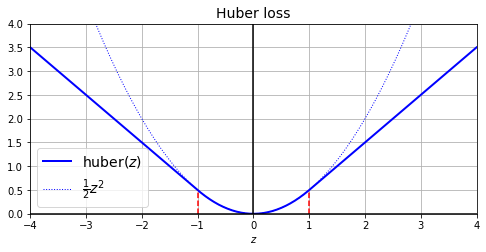

In [38]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [39]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [41]:
model.compile(loss=huber_fn, optimizer='nadam', metrics=['mae'])

In [42]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.5918 - mae: 0.9568 - val_loss: 0.2602 - val_mae: 0.5581
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2131 - mae: 0.5077 - val_loss: 0.2061 - val_mae: 0.4892


### Saving and Loading Modelas that contain Custom Components

In [43]:
model.save("my_model_with_a_custom_loss.h5")

In [44]:
model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn":huber_fn})

In [53]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss = tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [54]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [55]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.1812 - mae: 0.4896 - val_loss: 0.1767 - val_mae: 0.4775
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1787 - mae: 0.4823 - val_loss: 0.1731 - val_mae: 0.4703


In [56]:
model.save("my_model_with_a_custom_loss_threshold_2.h5")

In [57]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

- to avoid to define the threshold value when load a already computed model with a costumized loss fuction:

In [68]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return{**base_config, "threshold":self.threshold}

In [69]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [70]:
model.compile(loss=HuberLoss(2.0), optimizer="nadam", metrics=["mae"])

### Custom activation functions
- Custom Glorot initializer

In [71]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [73]:
def my_softplus(z):
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev = stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01*weights))

def my_positive_weights(weights):
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [76]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [77]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [78]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 1.5542 - mae: 0.8962 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.5943 - mae: 0.5256 - val_loss: 1.4399 - val_mae: 0.5137


In [79]:
model.save("my_model_with_many_custom_parts.h5")

In [80]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

In [81]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

In [82]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [83]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [84]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 1.5901 - mae: 0.8871 - val_loss: 1.4671 - val_mae: 0.5719
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.6168 - mae: 0.5327 - val_loss: 1.3017 - val_mae: 0.5177


### Custom Metrics

In [102]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [86]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [87]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [88]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 1ms/step - loss: 2.0982 - huber_fn: 0.4776
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.6052 - huber_fn: 0.2130: 0s - loss: 0.6364 - huber_fn: 


- the loss since the start of the epoch is the mean of all batch losses seen so far. Each batch loss is the sum of the weighted instance losses divided by the batch size (not the sum of weights, so the batch loss is not the weighted mean of the losses).
- the metric since the start of the epoch is equal to the sum of weighted instance losses divided by sum of all weights seen so far. In other words, it is the weighted mean of all the instance losses. Not the same thing.

In [109]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [110]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]])) 

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

In [111]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=2.9166667>

In [104]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [105]:
model.compile(loss=keras.losses.Huber(2.0), optimizer="nadam", weighted_metrics=[HuberMetric(2.0)])

In [112]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32),
                    epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2377 - huber_metric: 0.1930
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2279 - huber_metric: 0.1868


In [113]:
model.save("my_model_with_a_custom_metric.h5")

In [114]:
model = keras.models.load_model("my_model_with_a_custom_metric.h5",
                                custom_objects={"huber_fn": create_huber(2.0),
                                                "HuberMetric": HuberMetric})

In [119]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2151 - huber_metric: 0.1775
Epoch 2/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2126 - huber_metric: 0.1758


In [120]:
model.metrics[-1].result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.17577797>

### Custom Layers

In [124]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [125]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

In [126]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 2s 3ms/step - loss: 1.0631 - val_loss: 0.4457
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4562 - val_loss: 0.3798
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4029 - val_loss: 0.3548
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3851 - val_loss: 0.3464
Epoch 5/5
162/162 [==============================] - 0s 1ms/step - loss: 0.3586


0.3586341142654419

In [128]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name = "kernel", shape=[batch_input_shape[-1], self.units],
            initializer = "glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape)
        
    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)
    
    def compute_ouput_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shpe.as_list()[:-1] + [self.units])
    
    def get_config(self):
        base_config = super().get_config()
        return{**base_config, "units":self.units,
               "activation": keras.activations.serialize(self.activation)}

In [129]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

In [130]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 1.7899 - val_loss: 0.7606
Epoch 2/2
162/162 [==============================] - 0s 1ms/step - loss: 0.5254


0.5253510475158691

In [132]:
model.save("my_model_with_a_custom_layer.h5")

In [133]:
model = keras.models.load_model("my_model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})

Now let's create a layer with a different behavior during training and testing:

In [142]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [143]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    AddGaussianNoise(stddev=1.0),
    keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(1)
])

In [144]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 2.3857 - val_loss: 7.6082
Epoch 2/2
162/162 [==============================] - 0s 997us/step - loss: 0.7560


0.7559615969657898

### Computing Gradients w/ Autdoff

In [145]:
def f(w1, w2):
    return 3* w1**2 + 2*w1*w2

In [163]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [164]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)
    
gradients = tape.gradient(z, [w1, w2])

In [155]:
z

<tf.Tensor: shape=(), dtype=float32, numpy=105.0>

In [156]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [157]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
try:
    dz_dw2 = tape.gradient(z, w2)
except RuntimeError as ex:
    print(ex)

A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


In [158]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2) # works now!
del tape

In [160]:
dz_dw1, dz_dw2

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

In [165]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [166]:
gradients

[None, None]

In [167]:
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [168]:
with tf.GradientTape(persistent=True) as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tf.reduce_sum(tf.stack([tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)]), axis=0)
del tape

In [169]:
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [170]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [171]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

In [183]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

In [173]:
x = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=nan>]

### Custom Training Loops - Computing Gradients using Autodiff

In [184]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [185]:
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [186]:
def random_batch(X, y, batch_size = 32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [187]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

In [193]:
import time

mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 - loss: 0.0900 - mean_square: 858.5000


In [195]:
def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

In [197]:
progress_bar(6500, 10000, size=6)

' 6500/10000 [===>..]'

In [198]:
def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)

In [199]:
mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 [==============================] - loss: 0.0900 - mean_square: 858.5000


In [191]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [200]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables) #Compute the Gradient in regard to each trainable variable
        optimizer.apply_gradients(zip(gradients, model.trainable_variables)) #Gradient Descent Step
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
11610/11610 [==============================] - loss: 1.2371 - mean_absolute_error: 0.5722
Epoch 2/5
11610/11610 [==============================] - loss: 0.6774 - mean_absolute_error: 0.5280
Epoch 3/5
11610/11610 [==============================] - loss: 0.6351 - mean_absolute_error: 0.5177
Epoch 4/5
11610/11610 [==============================] - loss: 0.6384 - mean_absolute_error: 0.5181
Epoch 5/5
11610/11610 [==============================] - loss: 0.6440 - mean_absolute_error: 0.5222


In [207]:
optimizer

### TensorFlow Functions:
- When you want to boost a python function just transform it into TF Function

In [209]:
@tf.function
def tf_cube(x):
    return x ** 3

In [211]:
tf_cube(tf.constant(2))

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [212]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [214]:
tf_cube.python_function(2)

8

### AutoGraph

In [215]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))
concrete_function.graph

In [216]:
concrete_function(tf.constant(2.0))
concrete_function is tf_cube.get_concrete_function(tf.constant(2.0))

True

In [217]:
concrete_function.graph

In [218]:
ops = concrete_function.graph.get_operations()
ops

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [219]:
pow_op = ops[2]
list(pow_op.inputs)

[<tf.Tensor 'x:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [220]:
@tf.function
def add_10(x):
    condition = lambda i, x: tf.less(i, 10)
    body = lambda i, x: (tf.add(i, 1), tf.add(x, 1))
    final_i, final_x = tf.while_loop(condition, body, [tf.constant(0), x])
    return final_x

In [221]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [222]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

### Ex12:

- a) define two variables weights alpha and beta, shapes [-1,:] data type tf.float32 alpha = 1, beta=0:

In [ ]:
class MyLayer(keras.layers.Layer):
    def __init__(self, alpha = 1.0, beta=0.0, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.beta = beta
        self.activation = keras.activations.get(activation)
    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1:], self.alpha], initializer="ones")
        self.bias = self.add_weight(
            name="bias", shape=[batch_input_shape[-1:], self.beta], initializer="zeros")
        super().build(batch_input_shape)
        

- b)call method mean of std of each instance feature, tf.nn.moments(inputs, axes=-1, keepdims=True), returns mean and std**2 then retunr alphaX(X-mean)/(std-e) + Beta

In [228]:
class MyLayer(keras.layers.Layer):
    def __init__(self, eps=0.001, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
    
    def build(self, batch_input_shape):
        self.alpha = self.add_weight(
            name="kernel", shape=batch_input_shape[-1:], initializer="ones")
        self.beta = self.add_weight(
            name="bias", shape=batch_input_shape[-1:], initializer="zeros")
        super().build(batch_input_shape)
        
    def call(self, X):
        mean, var = tf.nn.moments(X[i], axes=-1, keepdims=True)
        return self.alpha * (X - mean)/(tf.sqrt(var)+self.eps) + self.beta
    
    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape
    
    def get_config(self):
        bae_config = super().get_config()
        return{**kwargs, "eps":self.eps}

- c) ensures that this new layer produces almost the same result as normalization layer:

In [229]:
X = X_train.astype(np.float32)

custom_layer_norm = MyLayer()
keras_layer_norm = keras.layers.LayerNormalization()

tf.reduce_mean(keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=0.22886726>

In [230]:
random_alpha = np.random.rand(X.shape[-1])
random_beta = np.random.rand(X.shape[-1])

custom_layer_norm.set_weights([random_alpha, random_beta])
keras_layer_norm.set_weights([random_alpha, random_beta])

tf.reduce_mean(keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=0.18172204>

### Ex 13

In [241]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

In [242]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [245]:
from tqdm import trange

In [246]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()

All epochs:   0%|                                                                                | 0/5 [00:00<?, ?it/s]


NameError: name 'OrderedDict' is not defined